In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

!pip3 install pyspellchecker
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
from textblob import Word

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.3 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [3]:
# Read 'train.csv' dataset and preview
raw_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
raw_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
# Get summary statistics
raw_df.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Overview of raw data

In [5]:
# Check raw data
print('Number of reviews:', raw_df.shape[0])
print('Unique cohesion values:', np.sort(raw_df.cohesion.unique()))
print('Unique syntax values:', np.sort(raw_df.syntax.unique()))
print('Unique vocabulary values:', np.sort(raw_df.vocabulary.unique()))
print('Unique phraseology values:', np.sort(raw_df.phraseology.unique()))
print('Unique grammar values:', np.sort(raw_df.grammar.unique()))
print('Unique conventions values:', np.sort(raw_df.conventions.unique()))

Number of reviews: 3911
Unique cohesion values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique syntax values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique vocabulary values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique phraseology values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique grammar values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Unique conventions values: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


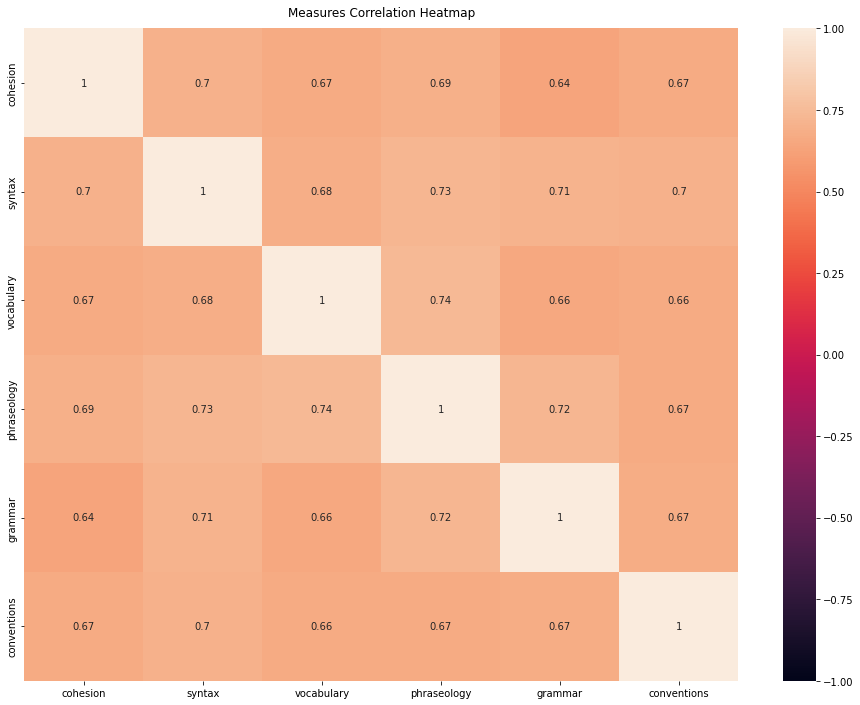

In [6]:
# Correlation matrix with given measure scores (outcomes)

plt.figure(figsize=(16, 12))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(raw_df[1:].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Measures Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

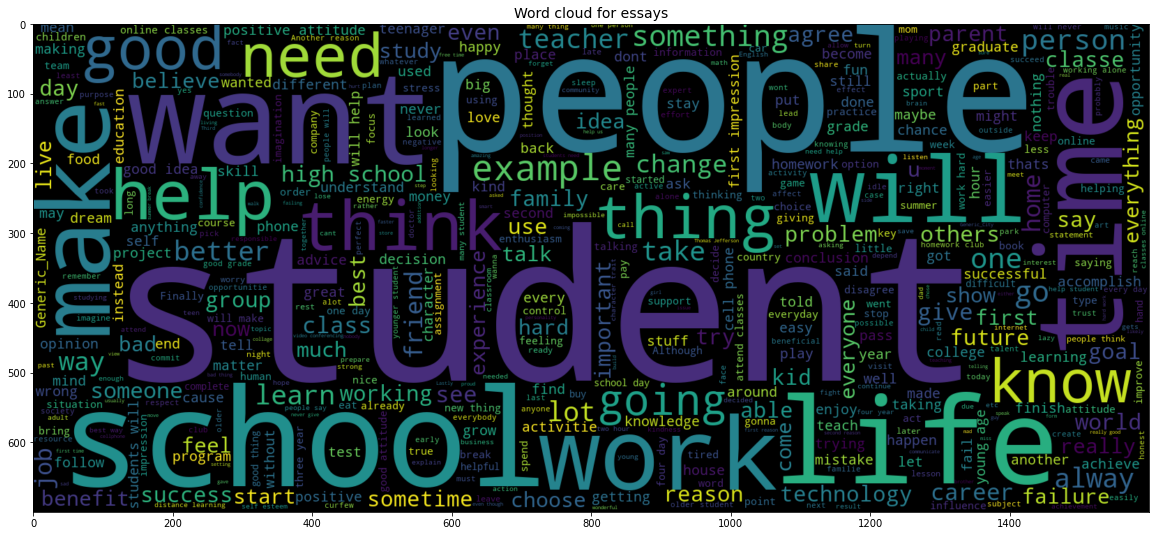

In [7]:
# Create a word cloud
plt.figure(figsize = (20,10))
wc = WordCloud(
    max_words = 500,
    width = 1600,
    height = 700).generate(" ".join(raw_df.full_text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for essays',fontsize=14);

## Feature Engineering

Before doing any feature engineering, split the data 70/10/20 (train/validate/test)

In [8]:
# copy the raw data
df = raw_df.copy(deep=True)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=21) # 20% for test
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=21) # 10% for validation
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
3047,D9AAEE4C9BCC,Do you think that influencing other is imporan...,3.5,3.5,2.5,3.0,3.0,3.0
2848,CEF302996231,"Dear Dr. Generic_Name,\n\nThank you for taking...",3.0,3.0,3.0,2.5,3.0,3.0
1138,584A4BB1E954,Should these summer projects be teacher-design...,2.5,3.0,3.0,2.5,3.0,3.0
2824,CDDCA13DB734,The determination make us to do something and ...,3.5,3.0,3.0,2.5,2.5,3.5
1298,63AB55DADABF,Do you think we should extend our school day? ...,4.0,4.0,4.0,3.5,4.5,3.5
...,...,...,...,...,...,...,...,...
3654,F58DF8739B42,Dear Mr. Principal today I want to talk abot h...,3.0,3.0,3.5,2.5,3.0,2.0
3034,D92BFF2AC7FD,Do you think is a good idea to change the scho...,3.5,3.5,3.0,3.0,3.0,3.0
2978,D5C7212A31FD,20/11/2010\n\nMr. reader`s how are you?\n\nThi...,2.5,2.5,2.0,2.5,2.0,2.0
1887,8E5E6211E4D6,Have you ever wondered how is it like being in...,3.0,3.0,3.5,3.5,3.5,3.0


Get an idea of essay lengths in the training data set

In [9]:
# check max and min lengths of essays
max_length = max(len(x.split()) for x in df_train['full_text'])
min_length = min(len(x.split()) for x in df_train['full_text'])

# calculate average length of essays
total_words = 0
for essay in df_train['full_text']:
    total_words += len(essay.split())
avg_length = total_words / df_train.shape[0]

print(f'longest essay has {max_length} words')
print(f'shortest essay has {min_length} words')
print(f'average essay has {avg_length:.0f} words')

longest essay has 1260 words
shortest essay has 54 words
average essay has 430 words


## **New Features**: Word Count & Average Word Length

In [10]:
# word counts and average word length
df_train['word_count'] = df_train['full_text'].map(lambda x:len(x.split()))
df_train['avg_word_len'] = df_train['full_text'].map(lambda x: np.mean([len(w) for w in str(x).split()]))
avg_word_len = round(np.mean(df_train['avg_word_len']))
print('Average Word Length: {}'.format(avg_word_len))

Average Word Length: 4


## **New Feature**: Repeated Word Count

In [11]:
def get_repeated_words(text):
    text_freq = WordCloud().process_text(text)
    repeated_words = dict((k, v) for k, v in text_freq.items() if v > 1)
    return repeated_words

def count_repeated_words(repeated_words_dict):
    number_of_repeated_words = len(repeated_words_dict)
    return number_of_repeated_words

def most_repeated_word(repeated_words_dict):
    max_word = max(repeated_words_dict, key=repeated_words_dict.get)
    return max_word

def count_most_repeated_word(repeated_words_dict, max_word):
    max_word_freq = repeated_words_dict[max_word]
    return max_word_freq

# add columns for words that are repeated more than once and the most repeated word
df_train['number_repeated_words'] = df_train.apply(lambda row: count_repeated_words(get_repeated_words(row['full_text'])), axis=1)
df_train['repeated_word_pct'] = df_train['number_repeated_words'] / df_train['word_count']
df_train['most_repeated_word'] = df_train.apply(lambda row: most_repeated_word(get_repeated_words(row['full_text'])), axis=1)
df_train['most_repeated_word_count'] = df_train.apply(lambda row: count_most_repeated_word(get_repeated_words(row['full_text']), most_repeated_word(get_repeated_words(row['full_text']))), axis=1)
df_train['most_repeated_word_pct'] = df_train['most_repeated_word_count'] / df_train['word_count']
print('Average Number of Repeated Words: {}'.format(df_train['number_repeated_words'].mean().round(0)))
print('Average Repeated Word %: {}'.format(df_train['repeated_word_pct'].mean().round(1)))
print('Average Most Repeated Word %: {}'.format(df_train['most_repeated_word_pct'].mean().round(1)))

Average Number of Repeated Words: 35.0
Average Repeated Word %: 0.1
Average Most Repeated Word %: 0.0


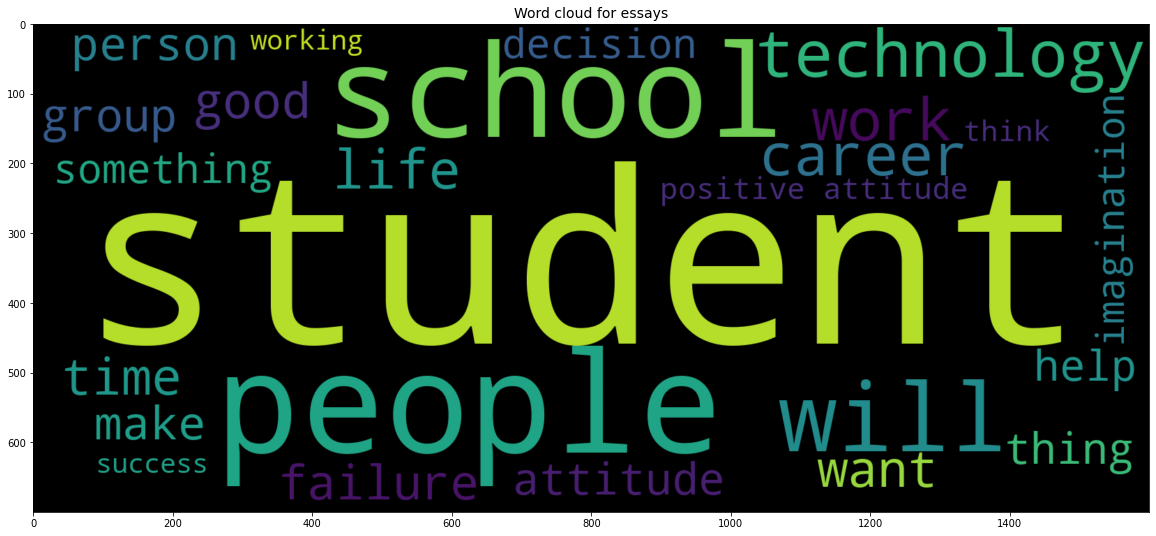

In [12]:
# Create a word cloud with the top 25 most repeated words
plt.figure(figsize = (20,10))
wc = WordCloud(
    max_words = 25,
    width = 1600,
    height = 700).generate(" ".join(df_train['most_repeated_word']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for essays',fontsize=14);

## **New Features**: Sentence Count & Average Sentence Length

In [13]:
df_train['sent_count'] = df_train['full_text'].apply(lambda x: len(sent_tokenize(x)))
avg_sent = round(df_train['sent_count'].mean())
print('Average Sentence Count: {}'.format(avg_sent))

df_train['avg_sent_len'] = df_train['full_text'].apply(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))
avg_sent_len = round(np.mean(df_train['avg_sent_len']))
print('Average Sentence Length: {}'.format(avg_sent_len))

Average Sentence Count: 18
Average Sentence Length: 30


## **New Feature**: Stop Word Count

In [14]:
# count no. of stop words
stop_words = set(stopwords.words('english'))
df_train['stopwords_count'] = df_train['full_text'].str.split().apply(lambda x: len(set(x) & stop_words))
df_train['stopwords_pct'] = df_train['stopwords_count'] / df_train['word_count']
print('Average Stopword Count: {}'.format(df_train['stopwords_count'].mean().round(0)))
print('Average Stopword %: {}'.format(df_train['stopwords_pct'].mean().round(1)))

Average Stopword Count: 47.0
Average Stopword %: 0.1


## **New Feature**: Spelling Error Count

In [15]:
# In order to check for spelling  errors, punctuation from contractions (e.g. won't, can't, etc.) must first be converted

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"he/she", "he or she", phrase)
    return phrase

# clean text for spell checking
def clean_punc(text):
    text = text.lower()
    #foction de replacement
    text = decontracted(text)
    text = re.sub(r"[^A-Za-z0-9]+"," ",text)
    return text

# instantiate SpellChecker class object
spell = SpellChecker()

# create a new column with count of spell_errors and count of spell_errors
df_train['text_wo_punc'] = [clean_punc(w) for w in df_train['full_text']]

# calculate the spelling errors
df_train['spell_error'] = df_train['text_wo_punc'].apply(lambda x: spell.unknown(word_tokenize(x)))
df_train['spell_error_count'] = df_train['spell_error'].str.len()
df_train['spell_error_pct'] = df_train['spell_error_count'] / df_train['word_count']
print('Average Spelling Errors: {}'.format(df_train['spell_error_count'].mean().round(0)))
print('Average Spelling Error %: {}'.format(df_train['spell_error_pct'].mean().round(1)))

Average Spelling Errors: 4.0
Average Spelling Error %: 0.0


In [16]:
# summary of table with 9 additional features
df_train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,avg_word_len,number_repeated_words,repeated_word_pct,most_repeated_word_count,most_repeated_word_pct,sent_count,avg_sent_len,stopwords_count,stopwords_pct,spell_error_count,spell_error_pct
count,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000
mean,3.130728,3.032504,3.243517,3.115453,3.032149,3.086679,430.233037,4.343685,34.565897,0.081224,13.357016,0.032978,18.263588,29.866262,47.004973,0.121213,3.937833,0.010181
std,0.661510,0.639906,0.580976,0.653017,0.693748,0.665115,187.689768,0.291595,14.928847,0.013373,6.498379,0.013491,10.209818,23.648682,11.139325,0.035774,5.766855,0.014918
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,54.000000,3.357724,4.000000,0.039216,2.000000,0.007653,1.000000,8.000000,9.000000,0.040417,0.000000,0.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000,298.000000,4.145697,24.000000,0.072207,9.000000,0.023084,11.000000,18.386905,39.000000,0.096682,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,404.000000,4.334572,33.000000,0.080780,12.000000,0.030769,17.000000,23.157895,47.000000,0.115538,2.000000,0.004264
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000,525.500000,4.523128,43.000000,0.089500,17.000000,0.040397,24.000000,33.125000,54.000000,0.140199,5.000000,0.014286
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1260.000000,5.560109,100.000000,0.152838,45.000000,0.125000,99.000000,280.000000,91.000000,0.327869,86.000000,0.207207


In [17]:
# display final dataframe
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,avg_word_len,...,most_repeated_word_count,most_repeated_word_pct,sent_count,avg_sent_len,stopwords_count,stopwords_pct,text_wo_punc,spell_error,spell_error_count,spell_error_pct
3047,D9AAEE4C9BCC,Do you think that influencing other is imporan...,3.5,3.5,2.5,3.0,3.0,3.0,238,4.466387,...,7,0.029412,13,18.307692,37,0.155462,do you think that influencing other is imporan...,"{imporant, influening}",2,0.008403
2848,CEF302996231,"Dear Dr. Generic_Name,\n\nThank you for taking...",3.0,3.0,3.0,2.5,3.0,3.0,473,4.327696,...,9,0.019027,22,21.500000,63,0.133192,dear dr generic name thank you for taking time...,{dr},1,0.002114
1138,584A4BB1E954,Should these summer projects be teacher-design...,2.5,3.0,3.0,2.5,3.0,3.0,203,5.192118,...,22,0.108374,12,16.916667,31,0.152709,should these summer projects be teacher design...,{},0,0.000000
2824,CDDCA13DB734,The determination make us to do something and ...,3.5,3.0,3.0,2.5,2.5,3.5,309,4.051780,...,4,0.012945,14,22.071429,44,0.142395,the determination make us to do something and ...,"{somenthig, wach}",2,0.006472
1298,63AB55DADABF,Do you think we should extend our school day? ...,4.0,4.0,4.0,3.5,4.5,3.5,760,4.218421,...,17,0.022368,41,18.536585,61,0.080263,do you think we should extend our school day n...,"{broring, broing, elementrary, elementray, 00p...",10,0.013158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,F58DF8739B42,Dear Mr. Principal today I want to talk abot h...,3.0,3.0,3.5,2.5,3.0,2.0,728,4.141484,...,19,0.026099,18,40.444444,52,0.071429,dear mr principal today i want to talk abot ho...,"{eargerness, actitude, responsale, trainig, le...",15,0.020604
3034,D92BFF2AC7FD,Do you think is a good idea to change the scho...,3.5,3.5,3.0,3.0,3.0,3.0,248,4.403226,...,7,0.028226,16,15.500000,45,0.181452,do you think is a good idea to change the scho...,"{stopted, ther}",2,0.008065
2978,D5C7212A31FD,20/11/2010\n\nMr. reader`s how are you?\n\nThi...,2.5,2.5,2.0,2.5,2.0,2.0,580,4.262069,...,10,0.017241,15,38.666667,42,0.072414,20 11 2010 mr reader s how are you this statem...,"{inpressed, firts, informe, haved, espresion, ...",24,0.041379
1887,8E5E6211E4D6,Have you ever wondered how is it like being in...,3.0,3.0,3.5,3.5,3.5,3.0,280,3.889286,...,11,0.039286,8,35.000000,35,0.125000,have you ever wondered how is it like being in...,"{postion, becuase, gerante, pepole}",4,0.014286


## Data Visualization

Measures are the categories over which each essay was scored. <br>
Features are the individual measurable characteristics of each essay. <br>
Each measure is assigned a color for the plots below.

In [18]:
measure_list = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

feature_list = ['word_count', 'avg_word_len','sent_count', 'avg_sent_len', 
                'stopwords_pct', 'spell_error_pct', 'repeated_word_pct', 'most_repeated_word_pct']

color_list = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

## Create box-and-whisker plots to visualize outliers and distribution of essays scores in terms of created feature vs measure score

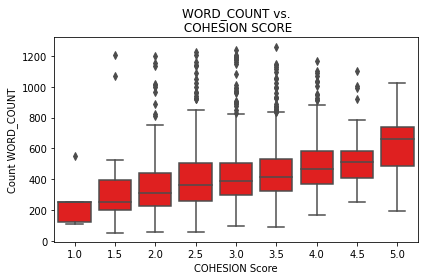

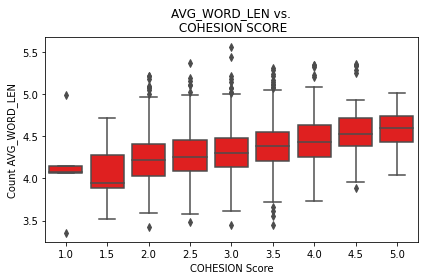

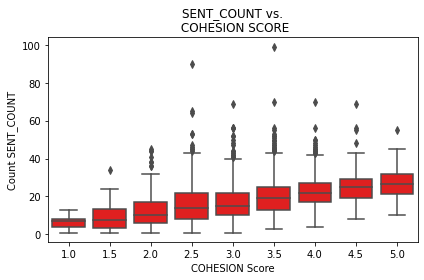

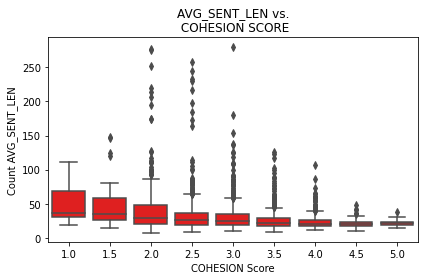

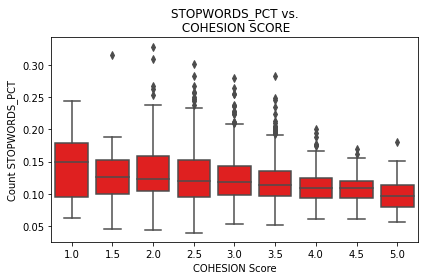

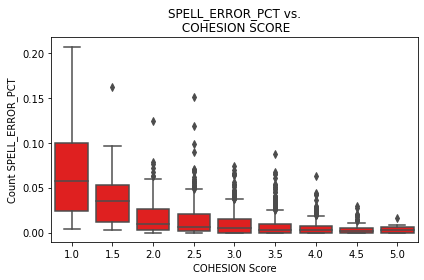

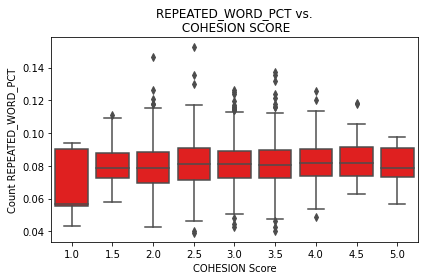

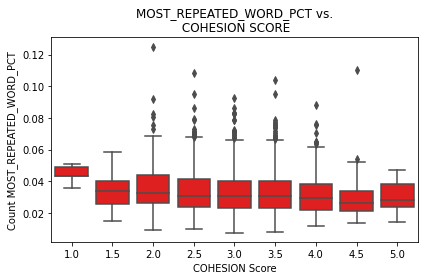

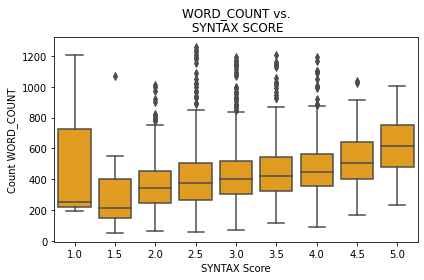

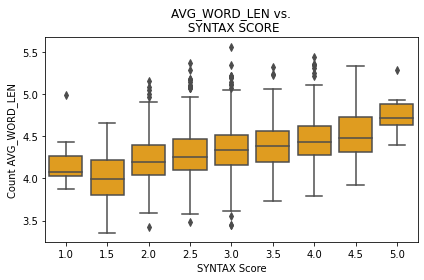

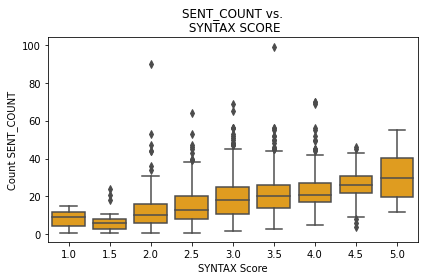

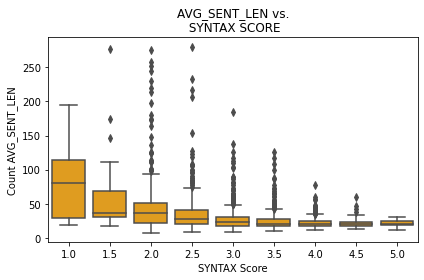

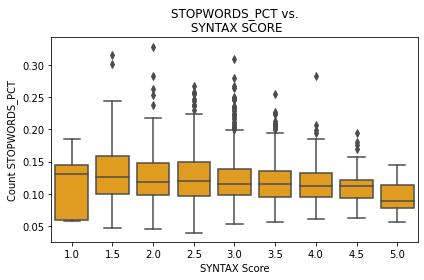

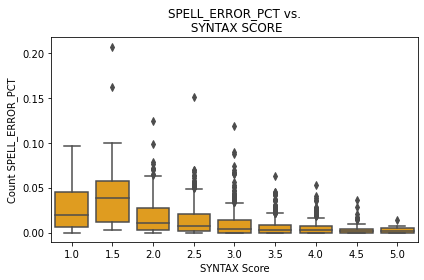

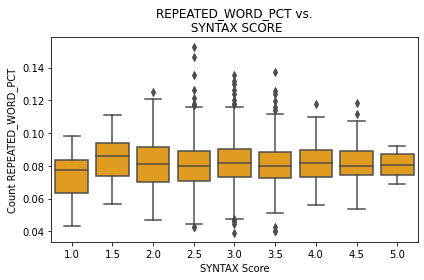

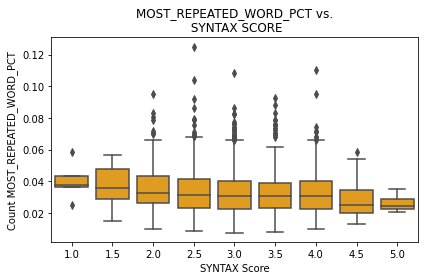

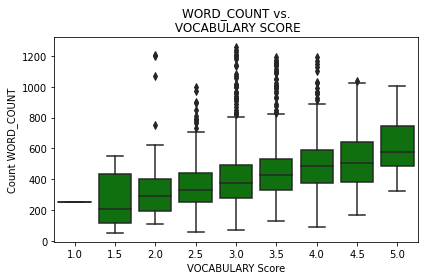

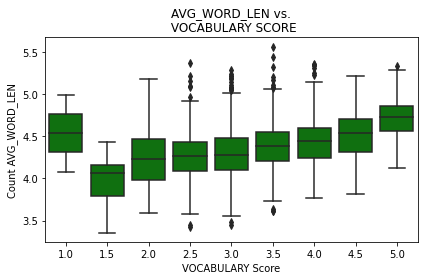

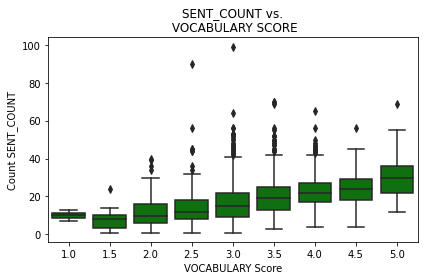

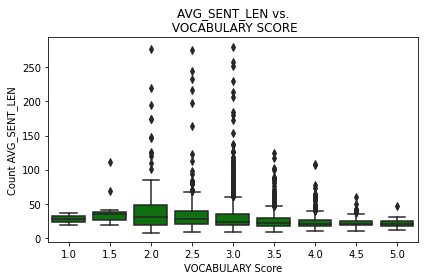

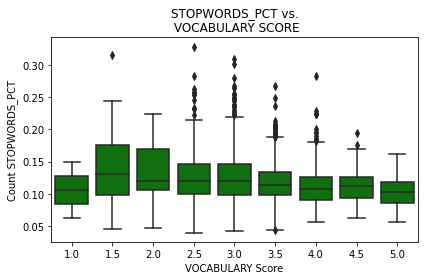

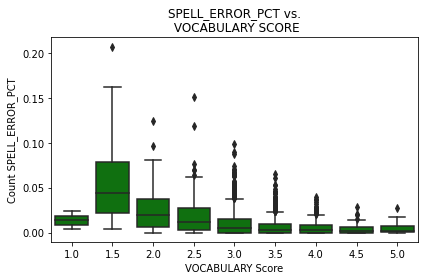

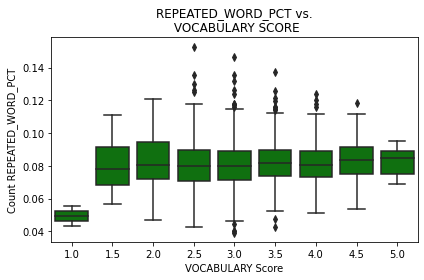

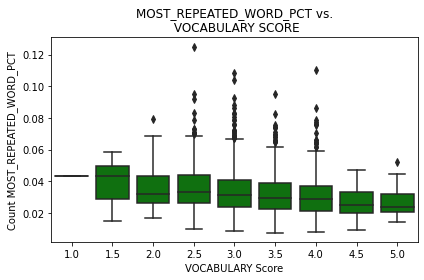

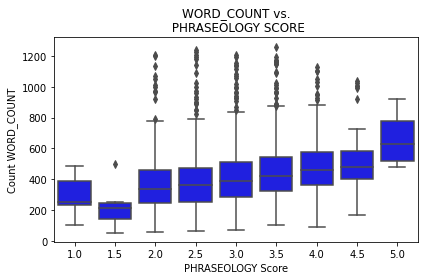

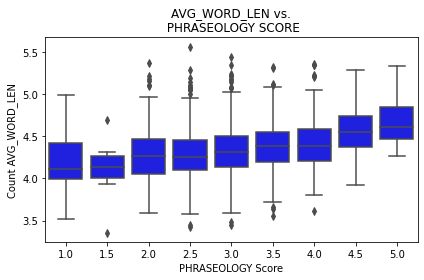

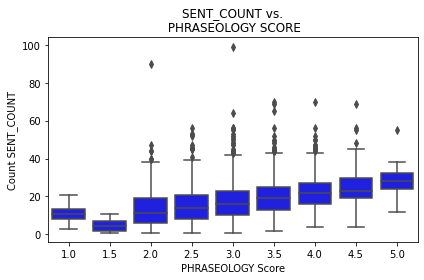

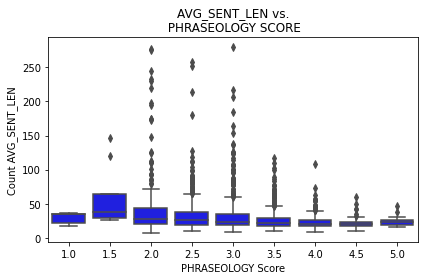

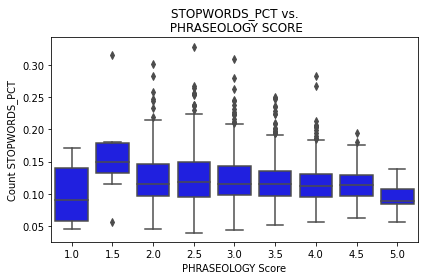

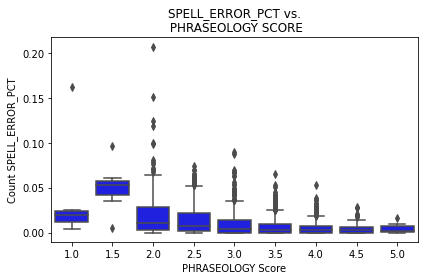

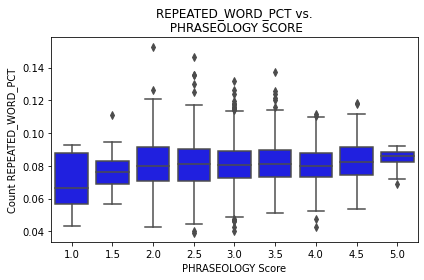

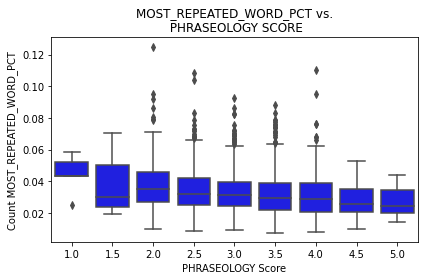

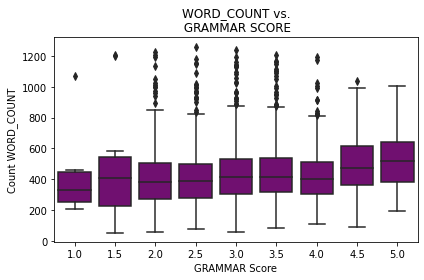

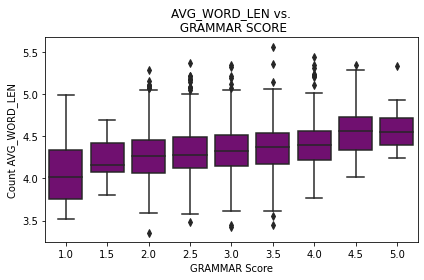

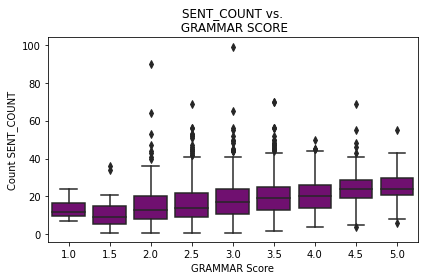

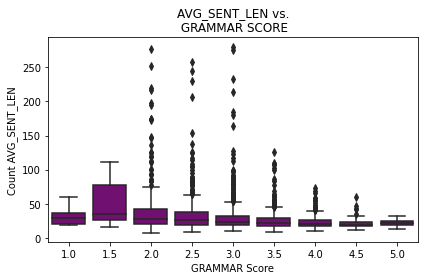

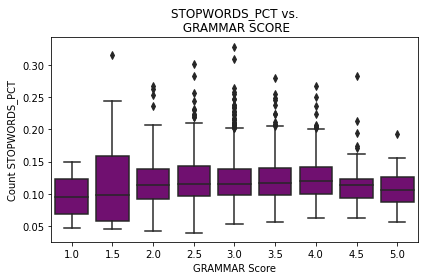

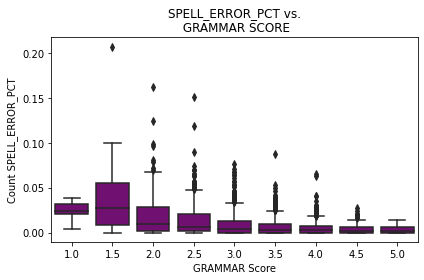

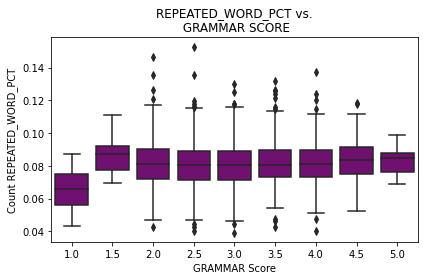

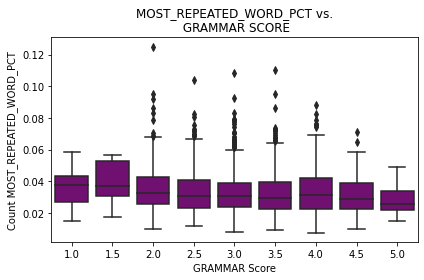

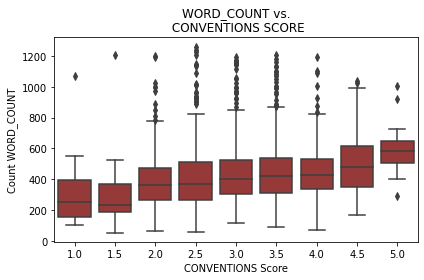

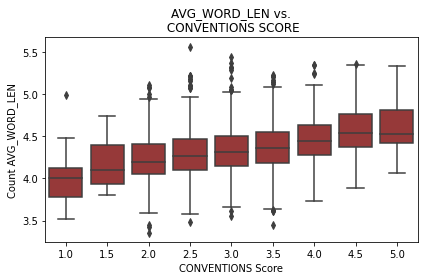

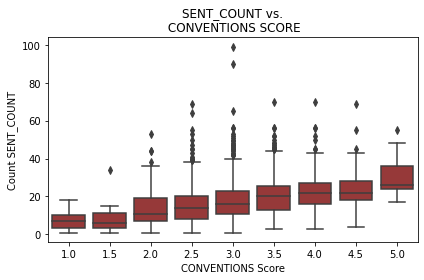

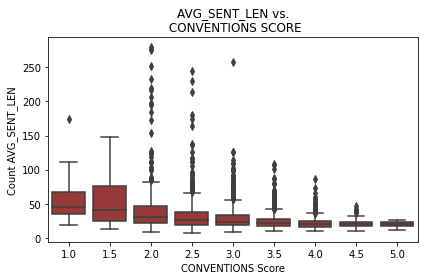

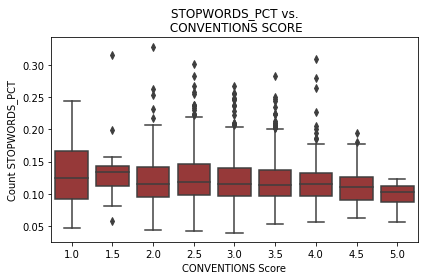

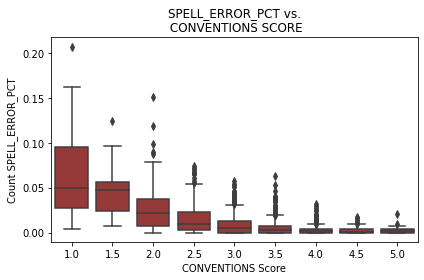

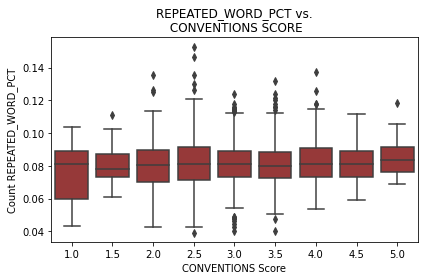

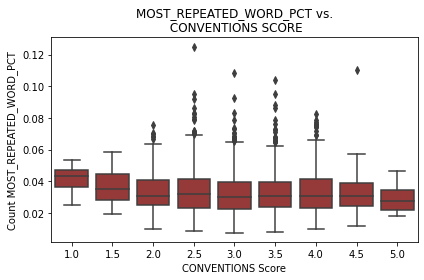

In [19]:
# create a function to box-and-whisker plot a new feature against a score measure
def box_whisker_plot_feature_vs_measure(df, feature, measure, color):
    
    # plot a bar chart to visualize distribution
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[measure], y=df[feature], data=pd.melt(df), color=color)
    plt.xlabel(f'{measure.upper()} Score')
    plt.ylabel(f'Count {feature.upper()}')
    plt.title(f'{feature.upper()} vs.\n {measure.upper()} SCORE')
    plt.tight_layout()
    plt.show()
    
    return

# loop through and create a scatter plot for each measure and each feature
for i in range(len(measure_list)):
    for feature in feature_list:
        box_whisker_plot_feature_vs_measure(df_train, feature, measure_list[i], color_list[i])

## Examine correlation between measures and new features

In [20]:
# correlation matrix with the new features
df_train.corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,word_count,avg_word_len,number_repeated_words,repeated_word_pct,most_repeated_word_count,most_repeated_word_pct,sent_count,avg_sent_len,stopwords_count,stopwords_pct,spell_error_count,spell_error_pct
cohesion,1.000000,0.686958,0.658251,0.682194,0.628904,0.667030,0.221115,0.266162,0.242903,0.037264,0.137982,-0.089436,0.328037,-0.238830,0.297924,-0.178805,-0.189859,-0.280394
syntax,0.686958,1.000000,0.682226,0.724932,0.708283,0.692027,0.189889,0.259107,0.204436,0.009087,0.112406,-0.077002,0.354200,-0.311214,0.292172,-0.106696,-0.214102,-0.297174
vocabulary,0.658251,0.682226,1.000000,0.740549,0.658368,0.662911,0.277275,0.260315,0.301560,0.034469,0.121825,-0.150617,0.339918,-0.203667,0.378945,-0.156912,-0.219811,-0.325689
phraseology,0.682194,0.724932,0.740549,1.000000,0.721904,0.663004,0.214840,0.202782,0.235284,0.011591,0.073691,-0.147412,0.300474,-0.209967,0.360482,-0.092530,-0.203951,-0.292317
grammar,0.628904,0.708283,0.658368,0.721904,1.000000,0.671116,0.085094,0.187600,0.107098,0.024433,0.024372,-0.056202,0.224800,-0.213449,0.222983,0.010743,-0.231600,-0.276777
conventions,0.667030,0.692027,0.662911,0.663004,0.671116,1.000000,0.138748,0.263702,0.151601,0.013186,0.102929,-0.030342,0.299999,-0.280209,0.224080,-0.078381,-0.399903,-0.460379
word_count,0.221115,0.189889,0.277275,0.214840,0.085094,0.138748,1.000000,-0.057760,0.931237,-0.151268,0.566494,-0.328452,0.630444,0.034346,0.771595,-0.766538,0.154598,-0.158027
avg_word_len,0.266162,0.259107,0.260315,0.202782,0.187600,0.263702,-0.057760,1.000000,0.027247,0.217206,0.184528,0.279224,0.152647,-0.229386,-0.083666,-0.038986,-0.089201,-0.070059
number_repeated_words,0.242903,0.204436,0.301560,0.235284,0.107098,0.151601,0.931237,0.027247,1.000000,0.181980,0.475005,-0.362414,0.627572,0.003362,0.742522,-0.728009,0.145556,-0.146523
repeated_word_pct,0.037264,0.009087,0.034469,0.011591,0.024433,0.013186,-0.151268,0.217206,0.181980,1.000000,-0.206671,-0.074577,-0.020823,-0.063237,-0.112617,0.089136,-0.007236,0.038273


In [21]:
# get high correlation feature pairs
# code from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# any correlations above 0.7 and below -0.7 are shown
corrFilter(df_train, .7)

stopwords_pct          word_count              -0.766538
                       number_repeated_words   -0.728009
syntax                 grammar                  0.708283
phraseology            grammar                  0.721904
syntax                 phraseology              0.724932
vocabulary             phraseology              0.740549
stopwords_count        number_repeated_words    0.742522
word_count             stopwords_count          0.771595
spell_error_count      spell_error_pct          0.839342
number_repeated_words  word_count               0.931237
cohesion               cohesion                      NaN
dtype: float64

From the correlation matrix and filter above, the top three highest correlations are:
- word_count and number_repeated_words
- word_count and stopwords_count
- number_repeated_words and stopwords_count

**Conclusions** <br>
Word length, average word length and sentence count have a positive relationship with the score
- Average sentence length, % of stopwords, % of word spell error and % of repeated words have negative relationship with the score
- Vocabulary has higher correlation with word count and spell error
- Syntax has higher correlation with sentence count and average sentence length, as well as % of repeated words
- Cohesion has higher correlation with average word length and % of stopwords
- Phraseology has higher correlation with % of repeated words

In [22]:
# Export final dataframe to .csv
df_train.to_csv('train_new_features.csv')